In [1]:
import os
import time
import xml.etree.ElementTree as ET
from collections import OrderedDict

import numpy as np
import pandas as pd

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

In [2]:
df0 = pd.read_csv(os.path.join('data', 'index'))
display(df0)

,Year,Form,State,Path
0,2014,990PF,NJ,download990xml_2015_1/201513209349103101_publi...
1,2014,990,OH,download990xml_2015_1/201503209349307025_publi...
2,2014,990,NY,download990xml_2015_1/201513179349306981_publi...
3,2014,990PF,MI,download990xml_2015_1/201503009349100100_publi...
4,2014,990,VA,download990xml_2015_1/201503149349301075_publi...
...,...,...,...,...
2698283,2020,990,NC,download990xml_2022/202230359349301528_public.xml
2698284,2020,990,NY,download990xml_2022/202240749349300524_public.xml
2698285,2019,990,AZ,download990xml_2022/202200349349300930_public.xml
2698286,2020,990,PA,download990xml_2022/202230409349300203_public.xml


In [3]:
paths = df0.loc[
    (df0['Year'] >= 2013) &
    (df0['Form'] == '990') &
    (df0['State'] == 'HI'), 'Path'].to_list()

paths = ['data/' + path for path in paths]

In [4]:
ns = {'ns0': 'http://www.irs.gov/efile'}
dic0 = OrderedDict()

dic0['Year'] =   'ns0:ReturnHeader/ns0:TaxYr'
dic0['EIN'] =    'ns0:ReturnHeader/ns0:Filer/ns0:EIN'
dic0['Name1'] =  'ns0:ReturnHeader/ns0:Filer/ns0:BusinessName/ns0:BusinessNameLine1Txt'
dic0['Name2'] =  'ns0:ReturnHeader/ns0:Filer/ns0:BusinessName/ns0:BusinessNameLine2Txt'

dic0['Grants'] = 'ns0:ReturnData/ns0:IRS990/ns0:CYContributionsGrantsAmt'
dic0['Prog'] =   'ns0:ReturnData/ns0:IRS990/ns0:CYProgramServiceRevenueAmt'
dic0['Invest'] = 'ns0:ReturnData/ns0:IRS990/ns0:CYInvestmentIncomeAmt'
dic0['Other'] =  'ns0:ReturnData/ns0:IRS990/ns0:CYOtherRevenueAmt'
dic0['Total'] =  'ns0:ReturnData/ns0:IRS990/ns0:CYTotalRevenueAmt'

In [5]:
list1 = []
for path in paths:
    with open(path, 'r') as f:
        text = f.read()
    root = ET.fromstring(text)
    dic1 = OrderedDict()
    for key, value in dic0.items():
        element = root.find(value, ns)
        if element is not None:
            dic1[key] = element.text
    list1.append(dic1)

In [12]:
df1 = pd.DataFrame(list1)
df1 = df1.fillna('').drop_duplicates().reset_index(drop=True)
df1['Name'] = (df1['Name1'] + ' ' + df1['Name2']).str.upper().str.strip()

dic1 = OrderedDict()
dic1['Year'] =   'int64'
dic1['EIN'] =    'int64'
dic1['Name'] =   'string'
dic1['Grants'] = 'int64'
dic1['Prog'] =   'int64'
dic1['Invest'] = 'int64'
dic1['Other'] =  'int64'
dic1['Total'] =  'int64'

df1 = df1.astype(dic1).loc[:, dic1.keys()]
display(df1)

,Year,EIN,Name,Grants,Prog,Invest,Other,Total
0,2014,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,45916,0,0,0,45916
1,2014,990215149,HOSPICE MAUI INC,833974,3775372,712,8701,4618759
2,2014,990347359,KANU I KA PONO INC,454528,12624,46,28439,495637
3,2014,996008823,AFL HOTEL & RESTAURANT WORKERS HEALTH & WELFAR...,0,97474788,630003,-133297,97971494
4,2014,200245026,SURFING THE NATIONS,3087018,548344,74,102423,3737859
...,...,...,...,...,...,...,...,...
7278,2020,990325194,ST FRANCIS COMMUNITY HEALTH SERVICES,1890439,21569976,11006,225,23471646
7279,2020,990221127,MAUI YOUTH AND FAMILY SERVICES INC,1436686,2056525,113708,32466,3639385
7280,2020,990273644,KONA ADULT DAY CENTER,62217,109806,129,5150,177302
7281,2020,463368161,KAMA'AINA HALE APARTMENTS,0,1561338,0,0,1561338


In [13]:
max(df1[['Grants','Prog','Invest','Other']].sum(axis=1) - df1['Total'])

0

In [14]:
df2 = df1[['EIN', 'Name']].groupby('EIN').last().reset_index()
df3 = pd.merge(df1.drop(['Name'], axis=1), df2)[df1.columns]
display(df3)

,Year,EIN,Name,Grants,Prog,Invest,Other,Total
0,2014,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,45916,0,0,0,45916
1,2015,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,43337,0,0,0,43337
2,2016,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,12290,0,0,0,12290
3,2017,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,101107,0,0,0,101107
4,2018,452488652,FRIENDS OF CHALLENGER CENTER HAWAII INC,36928,0,0,0,36928
...,...,...,...,...,...,...,...,...
7278,2020,990320097,MAKU'U FARMERS ASSOCIATION,8580,3200,0,0,11780
7279,2020,990334971,KAPALUA MAUI CHARITIES INC,0,0,0,0,0
7280,2020,451634719,HUAKAILANI SCHOOL FOR GIRLS INC,6933,470750,18,0,477701
7281,2020,851039176,KAUAI REGION MEDICAL GROUP,0,0,11,1415091,1415102


In [15]:
top = df3[df3['Year'] == 2019].nlargest(25, 'Total')['Name'].to_list()
display(top)

["HAWAI'I PACIFIC HEALTH GROUP RETURN",
 "THE QUEEN'S MEDICAL CENTER",
 'ALOHACARE',
 'HAWAII DENTAL SERVICE',
 "HAWAI'I PACIFIC HEALTH",
 'CASTLE MEDICAL CENTER DBA ADVENTIST HEALTH CASTLE',
 'KAUAI ISLAND UTILITY COOPERATIVE',
 "THE QUEEN'S HEALTH SYSTEMS",
 'AFL HOTEL & RESTAURANT WORKERS HEALTH & WELFARE PLAN',
 'PUNAHOU SCHOOL',
 'HAWAII PACIFIC UNIVERSITY',
 'HAWAII COMMUNITY FOUNDATION',
 'SUTTER INSURANCE SERVICES CORPORATION',
 'QUEEN EMMA LAND COMPANY',
 'UNIVERSITY OF HAWAII FOUNDATION',
 "'IOLANI SCHOOL",
 'WAIANAE DISTR COMPREHENSIVE HEALTH & HOSPITAL BOARD INC',
 'CHAMINADE UNIVERSITY OF HONOLULU',
 'POLYNESIAN CULTURAL CENTER',
 'HAWAII CARPENTERS HEALTH & WELFARE FUND',
 'UNIVERSITY CLINICAL EDUCATION & RESEARCH ASSOCIATES (UCERA)',
 'ILWU LOCAL 142 HEALTH AND WELFARE TRUST',
 "KAUA'I MEDICAL CLINIC",
 'HAWAII FOODBANK INC',
 'REHABILITATION HOSPITAL OF THE PACIFIC']

In [16]:
df4 = df3.loc[
    (df3['Year'] >= 2014) &
    (df3['Year'] <= 2019) &
    (df3['Name'].isin(top))]

df4 = df4.melt(
    id_vars=['Year', 'Name'],
    value_vars=['Grants', 'Prog', 'Invest', 'Other'],
    var_name='Revenue',
    value_name='Dollars')

dic2 = OrderedDict()
dic2["HAWAI'I PACIFIC HEALTH GROUP RETURN"] = 'HAWAII PACIFIC\nHEALTH GROUP' 
dic2["THE QUEEN'S MEDICAL CENTER"] = 'QUEENS MEDICAL\nCENTER'
dic2['ALOHACARE'] = 'ALOHACARE'
dic2['HAWAII DENTAL SERVICE'] = 'HAWAII DENTAL\nSERVICE'
dic2["HAWAI'I PACIFIC HEALTH"] = 'HAWAII PACIFIC\nHEALTH'
dic2['CASTLE MEDICAL CENTER DBA ADVENTIST HEALTH CASTLE'] = 'CASTLE MEDICAL\nCENTER'    
dic2['KAUAI ISLAND UTILITY COOPERATIVE'] = 'KAUAI\nUTILITY'
dic2["THE QUEEN'S HEALTH SYSTEMS"] = 'QUEENS HEALTH\nSYSTEMS'
dic2['AFL HOTEL & RESTAURANT WORKERS HEALTH & WELFARE PLAN'] = 'AFL HOTEL\n& RESTAURANT'
dic2['PUNAHOU SCHOOL'] = 'PUNAHOU SCHOOL'
dic2['HAWAII PACIFIC UNIVERSITY'] = 'HAWAII PACIFIC\nUNIVERSITY'
dic2['HAWAII COMMUNITY FOUNDATION'] = 'HAWAII COMMUNITY\nFOUNDATION'
dic2['SUTTER INSURANCE SERVICES CORPORATION'] = 'SUTTER\nINSURANCE'
dic2['QUEEN EMMA LAND COMPANY'] = 'QUEEN EMMA\nLAND CO'
dic2['UNIVERSITY OF HAWAII FOUNDATION'] = 'UH FOUNDATION' 
dic2["'IOLANI SCHOOL"] = 'IOLANI SCHOOL'
dic2['WAIANAE DISTR COMPREHENSIVE HEALTH & HOSPITAL BOARD INC'] = 'WAIANAE HEALTH\nBOARD INC'
dic2['CHAMINADE UNIVERSITY OF HONOLULU'] = 'CHAMINADE\nUNIVERSITY'
dic2['POLYNESIAN CULTURAL CENTER'] = 'POLYNESIAN\nCULTURAL CENTER'
dic2['HAWAII CARPENTERS HEALTH & WELFARE FUND'] = 'HAWAII CARPENTER\nHEALTH FUND'
dic2['UNIVERSITY CLINICAL EDUCATION & RESEARCH ASSOCIATES (UCERA)'] = 'UNIVERSITY\nCLINICAL'
dic2['ILWU LOCAL 142 HEALTH AND WELFARE TRUST'] = 'LOCAL 142\nHEALTH TRUST'
dic2["KAUA'I MEDICAL CLINIC"] = 'KAUAI\nMEDICAL'
dic2['HAWAII FOODBANK INC'] = 'HAWAII\nFOODBANK'
dic2['REHABILITATION HOSPITAL OF THE PACIFIC'] = 'REHABILITATION\nHOSPITAL OF PAC'

dic3 = OrderedDict()
dic3['Grants'] = 'Contributions, grants'
dic3['Prog'] = 'Program service'
dic3['Invest'] = 'Investments'
dic3['Other'] = 'Other'

df4['Name'] =    df4['Name']   .replace(dic2).astype('category').cat.reorder_categories(dic2.values())
df4['Revenue'] = df4['Revenue'].replace(dic3).astype('category').cat.reorder_categories(dic3.values())
display(df4)

,Year,Name,Revenue,Dollars
0,2014,AFL HOTEL\n& RESTAURANT,"Contributions, grants",0
1,2015,AFL HOTEL\n& RESTAURANT,"Contributions, grants",0
2,2016,AFL HOTEL\n& RESTAURANT,"Contributions, grants",0
3,2017,AFL HOTEL\n& RESTAURANT,"Contributions, grants",0
4,2018,AFL HOTEL\n& RESTAURANT,"Contributions, grants",0
...,...,...,...,...
571,2019,HAWAII COMMUNITY\nFOUNDATION,Other,109946
572,2016,HAWAII\nFOODBANK,Other,153556
573,2017,HAWAII\nFOODBANK,Other,139111
574,2018,HAWAII\nFOODBANK,Other,130284


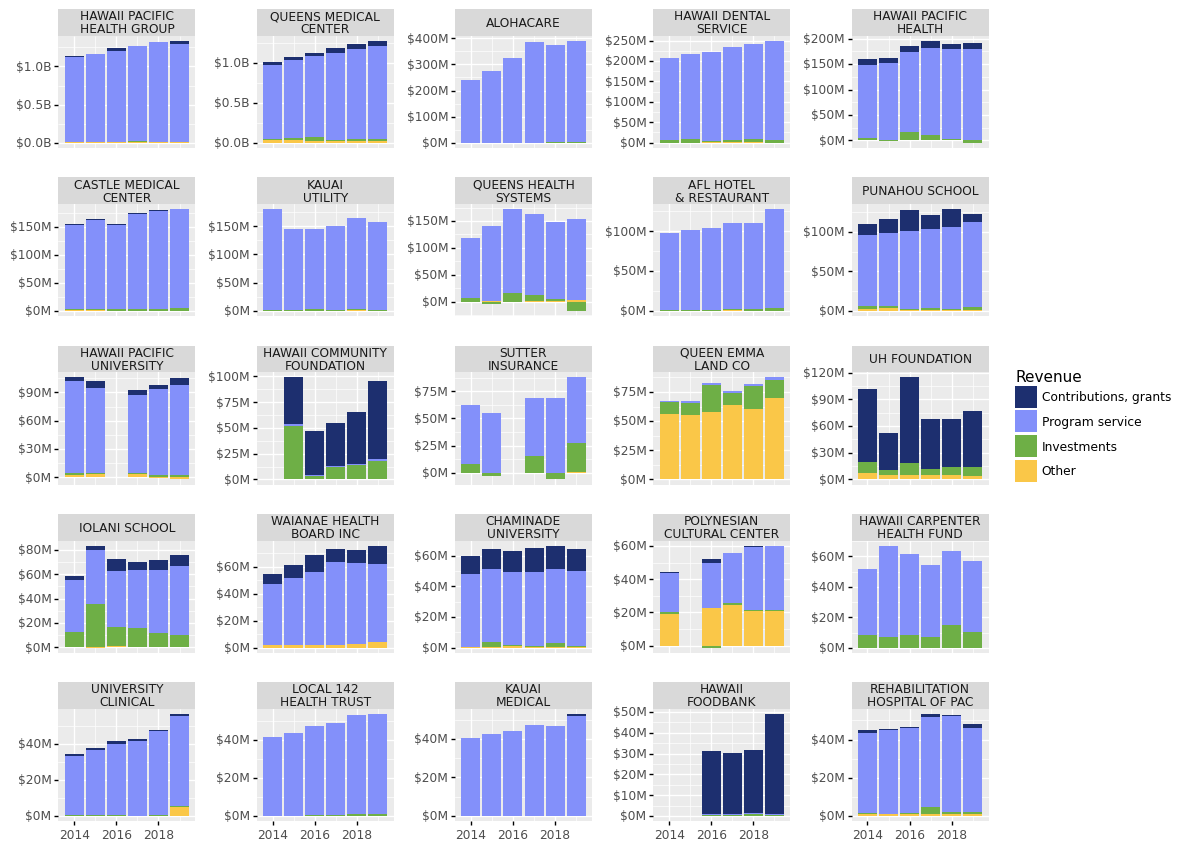

<ggplot: (8760678971757)>

In [17]:
width = 12
ncol = 5
nrow = np.ceil(len(df4['Name'].unique())/ncol)

colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748' ,'#FF8C00']

def y_label(xs):
    if max(xs) > 5e8: return [f'${x/1e9:.1f}B' for x in xs]
    else: return [f'${x/1e6:.0f}M' for x in xs]

p1 = (p9.ggplot(df4)
    + p9.facet_wrap('Name', ncol=ncol, scales='free_y')
    + p9.theme(figure_size=(width, 0.85*width/ncol*nrow))
    + p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.45})

    + p9.geom_col(p9.aes(x='Year', y='Dollars', fill='Revenue'))
    + p9.xlab('')
    + p9.ylab('')
    + p9.scale_fill_manual(values=colors)
    + p9.scale_y_continuous(labels=y_label))

display(p1)